In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.table import Table
from astropy import units as u
from astropy import coordinates as coords
# from astroquery.simbad import Simbad
import astroquery
plt.style.use("fivethirtyeight")

import gwb
import sys
sys.path.append("../")
import groupten

# Data

In [17]:
tgas = gwb.TGASData("../../gaia-wide-binaries/data/stacked_tgas.fits")

In [3]:
# save data for modelling
np.savez('../data/pmdata.npz',
         ra=df.tgas_ra.values, dec=df.tgas_dec.values,
         M_data=M_data, cov_data=cov_data, x_data=x_data)

NameError: name 'df' is not defined

In [16]:
d = np.load("../data/pmdata.npz")
x_data = d['x_data']/1e3
cov_data = d['cov_data']
M_data = d['M_data']
print(x_data.shape, cov_data.shape, M_data.shape)

(45, 3) (45, 3, 3) (45, 2, 3)


In [3]:
df = groupten.load_allstars()

In [11]:
a.df.to_csv("../data/allstars.csv")

In [2]:
d = groupten.DataLoader()

In [3]:
x_data,cov_data,M_data = d.get_group(0)

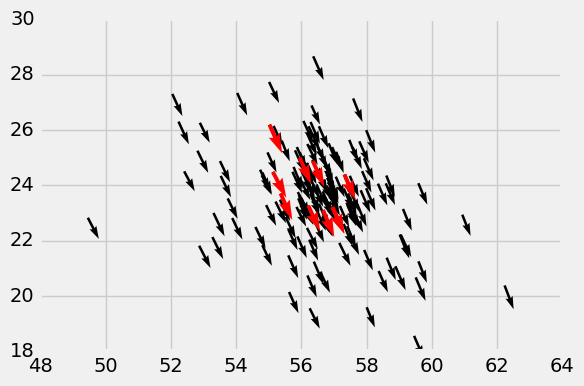

In [8]:
ii = np.random.randint(0, high=150, size=10,)
g = d.df.groupby("group_id").get_group(0)
plt.quiver(g.ra, g.dec, g.pmra, g.pmdec,);
s = g.iloc[ii]
plt.quiver(s.ra, s.dec, s.pmra, s.pmdec, color='red');

In [9]:
ii

array([ 59, 122, 141,   3, 112,  45,  38,   3,  94, 125])

In [10]:
import tensorflow as tf
from edward.models import Normal, Uniform
import edward as ed

In [5]:
sess = tf.InteractiveSession()

## on the fly fake data

In [3]:
ra = np.array([45., 45.5])
dec =np.array([30.2, 30.7])

# N, 2, 3
M_data = np.array(
    [[[-np.sin(rr), np.cos(rr), 0.],
     [-np.sin(dd)*np.cos(rr), -np.sin(dd)*np.sin(rr), np.cos(dd)]]
     for rr, dd in zip(np.deg2rad(ra), np.deg2rad(dec))])

v_true = np.array([50.3, -50.1, 22.6])
r_true = np.array([5.2, 10.2])
vtan_true = np.matmul(M_data,v_true)
x_true = np.concatenate(
    (1./r_true[:,None], vtan_true/r_true[:,None]), axis=1)

In [4]:
fakecov = np.array([np.diag(np.abs(xx)*0.08) for xx in x_true])

x_obs = np.array([np.random.multivariate_normal(xx, cc) for xx, cc in zip(x_true, fakecov**2)])
x_test = np.array([np.random.multivariate_normal(xx, cc) for xx, cc in zip(x_true, fakecov**2)])


## Model

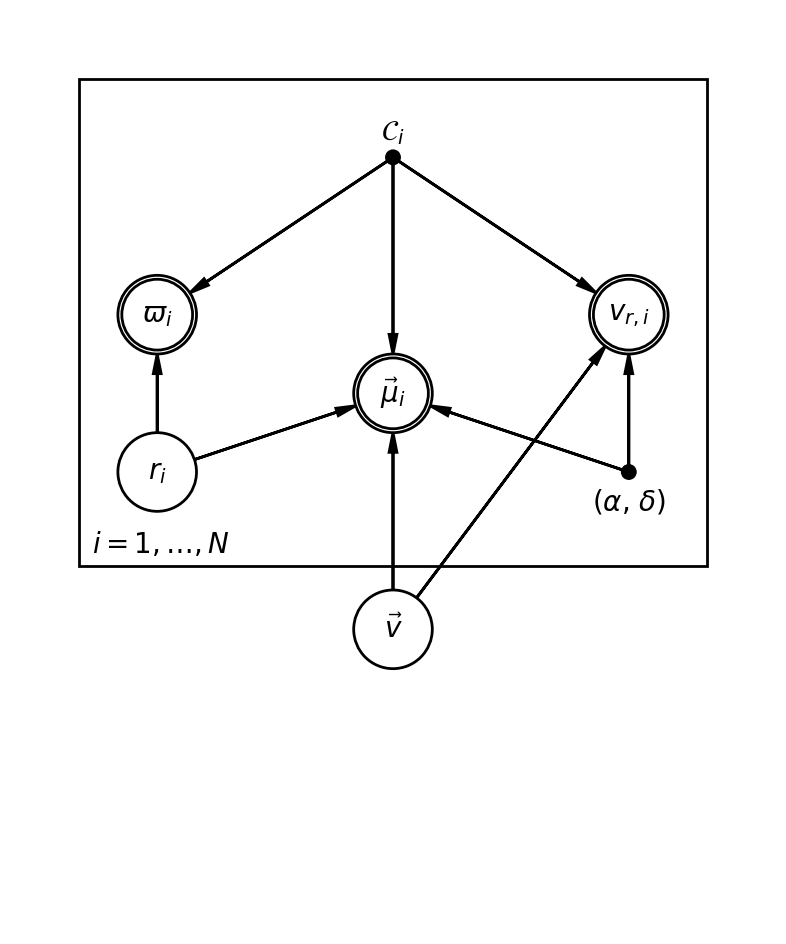

In [5]:
from IPython.display import Image
Image(filename='../../arv/pgm_samev.png', width=300)

In [85]:
N = 10  # number of stars
D = 3  # data dimension (parallax, pmra, pmdec)

# The observable `x` is 1d array of (N, 3) array of (parallax, pmra, pmdec) 
# Covariance `cov` is array (N) of covariance matrix (D,D) for stars 

# x_hat = tf.placeholder(tf.float32, [N, D])    # p_i, pmra_i, pmdec_i
cov = tf.placeholder(tf.float32, [N,D,D])
M = tf.placeholder(tf.float32, [N, 2, 3])   # projection matrix

v = ed.models.MultivariateNormalFull(mu=tf.zeros(3), sigma=tf.eye(3)*50.**2)
# None of these priors are good, but just for tryout
# r = ed.models.Normal(mu=tf.ones(N)*100., sigma=50.)
r = ed.models.Uniform(a=tf.ones(N)*1e-4, b=tf.ones(N)*200.)

V = tf.tile(tf.reshape(v, [1,3,1]), [N,1,1])
vtan = tf.reshape(tf.matmul(M, V), [N, 2])

p = tf.reshape(1./r, [-1,1])
xmu = tf.concat([p, vtan*p], 1)
x = ed.models.MultivariateNormalFull(mu=xmu, sigma=cov)

In [8]:
# # variational inference -- not working
# qr = ed.models.Normal(mu=tf.Variable(1./x_data[:N,0], dtype=tf.float32),
#                       sigma=tf.nn.softplus(tf.Variable([2.]*N)))
# qv = ed.models.MultivariateNormalFull(mu=tf.Variable([0.,0.,0.]),
#                                       sigma=tf.nn.softplus(tf.Variable(tf.eye(3))))

# data = {x: x_data[:N],
#         cov: cov_data[:N]**2,
#         M: M_data[:N]}
# inference = ed.KLqp({r:qr, v:qv}, data=data)
# inference.run()

   1/1000 [  0%]                                ETA: 1632s | Loss: 822990895841280.000

InvalidArgumentError: LLT decomposition was not successful. The input might not be valid.
	 [[Node: inference_4784912144/0/MultivariateNormalFull_2/OperatorPDFull/init/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_4784912144/0/Softplus_1)]]

Caused by op 'inference_4784912144/0/MultivariateNormalFull_2/OperatorPDFull/init/Cholesky', defined at:
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-98d00c872ea0>", line 11, in <module>
    inference.run()
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/inferences/inference.py", line 101, in run
    self.initialize(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/inferences/klqp.py", line 81, in initialize
    return super(KLqp, self).initialize(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/inferences/variational_inference.py", line 64, in initialize
    self.loss, grads_and_vars = self.build_loss_and_gradients(var_list)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/inferences/klqp.py", line 120, in build_loss_and_gradients
    return build_reparam_loss_and_gradients(self, var_list)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/inferences/klqp.py", line 368, in build_reparam_loss_and_gradients
    qz_copy = copy(qz, scope=scope)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/util/random_variables.py", line 244, in copy
    new_rv = rv.__class__(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/edward/models/random_variable.py", line 65, in __init__
    super(RandomVariable, self).__init__(*args, **kwargs)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/contrib/distributions/python/ops/mvn.py", line 716, in __init__
    cov = operator_pd_full.OperatorPDFull(sigma, verify_pd=validate_args)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/contrib/distributions/python/ops/operator_pd_full.py", line 90, in __init__
    chol = linalg_ops.cholesky(matrix)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 244, in cholesky
    result = _op_def_lib.apply_op("Cholesky", input=input, name=name)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): LLT decomposition was not successful. The input might not be valid.
	 [[Node: inference_4784912144/0/MultivariateNormalFull_2/OperatorPDFull/init/Cholesky = Cholesky[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](inference_4784912144/0/Softplus_1)]]


In [16]:
qr.mu.eval(), qv.mu.eval(), qv.sigma.eval()

(array([  5.40520239,  10.81970215], dtype=float32),
 array([ 49.76608276, -52.34514999,  23.6174984 ], dtype=float32),
 array([[ 17.32111359,   0.8629334 ,   6.67371941],
        [  0.8629334 ,  15.67647457,   6.30691862],
        [  6.67371941,   6.30691862,   6.54391766]], dtype=float32))

In [42]:
qr.mean().eval(), qr.std().eval(), qv.mean().eval()#, qv.std().eval()

(array([ 5.72170925,  9.74118233], dtype=float32),
 array([ 0.4196336 ,  0.40568635], dtype=float32),
 array([ 50.47658539, -49.26055908,  21.7446003 ], dtype=float32))

In [88]:
qr.params.eval()[-1]

array([ 135.45057678,  140.70744324,  129.39604187,  135.53248596,
        138.56848145,  135.37910461,  141.08805847,  136.49835205,
        146.07971191,  138.82658386], dtype=float32)

In [86]:
# MC sampling
n_sample = 10000
# ii = [10,15,17, 30, 65,66,43,55,56]
qr = ed.models.Empirical(tf.Variable(np.repeat((1./x_data[ii,0]*1e3)[None,:], n_sample, 0), dtype=tf.float32))

# vi = np.concatenate((np.repeat((x_data[ii,1:]/x_data[ii,0][:,None]*4.74).mean(axis=0)[None, :], n_sample, axis=0),
#                      np.random.normal(scale=30, size=n_sample)[:,None]), axis=1)
# vi = np.einsum('jk,ij->ik', M_data[0], vi)
# qv = ed.models.Empirical(tf.Variable(vi, dtype=tf.float32))
vi = np.random.multivariate_normal([0.,0.,0.], np.eye(3)*30.**2, n_sample)
print(vi[0])
qv = ed.models.Empirical(tf.Variable(vi, dtype=tf.float32))

data = {x: x_data[ii]/1e3,
        cov: cov_data[ii]/1e6,
        M: M_data[ii,:2,:]}
inference = ed.HMC({r:qr, v:qv}, data)

# what's the right step size?
inference.run(step_size=.01)

[-39.74795089  38.39905271  16.69524884]
10000/10000 [100%] ██████████████████████████████ Elapsed: 54s | Acceptance Rate: 0.928


In [76]:
qr.mean().eval(), qr.std().eval(), qv.mean().eval(), qv.std().eval()

(array([ 140.20429993,  139.37532043,  124.99137878,  143.25579834,
         139.20199585,  142.52323914,  148.28569031,  142.50091553,
         146.16664124,  137.91955566], dtype=float32),
 array([ 1.1498903 ,  1.89298856,  2.18724871,  1.88481092,  1.73884785,
         1.67337334,  4.49417162,  2.1581893 ,  0.9755941 ,  1.15389371], dtype=float32),
 array([-5.22805262, -2.40661907, -9.26592159], dtype=float32),
 array([ 3.79822469,  5.54936075,  3.09216356], dtype=float32))

In [57]:
qr.mean().eval(), qr.std().eval(), qv.mean().eval(), qv.std().eval()

(array([ 140.53715515,  139.85772705,  125.66333008,  141.97770691,
         139.08911133,  141.35702515,  147.85275269,  142.23852539,
         146.39074707,  136.95906067], dtype=float32),
 array([ 1.41790736,  1.33851576,  1.93526626,  2.14062572,  1.46099198,
         2.60478473,  4.71299887,  2.0674665 ,  1.31314731,  0.99463308], dtype=float32),
 array([-4.46024799, -1.26715338, -8.64957905], dtype=float32),
 array([ 3.28732276,  4.77433729,  2.69701266], dtype=float32))

In [48]:
import corner

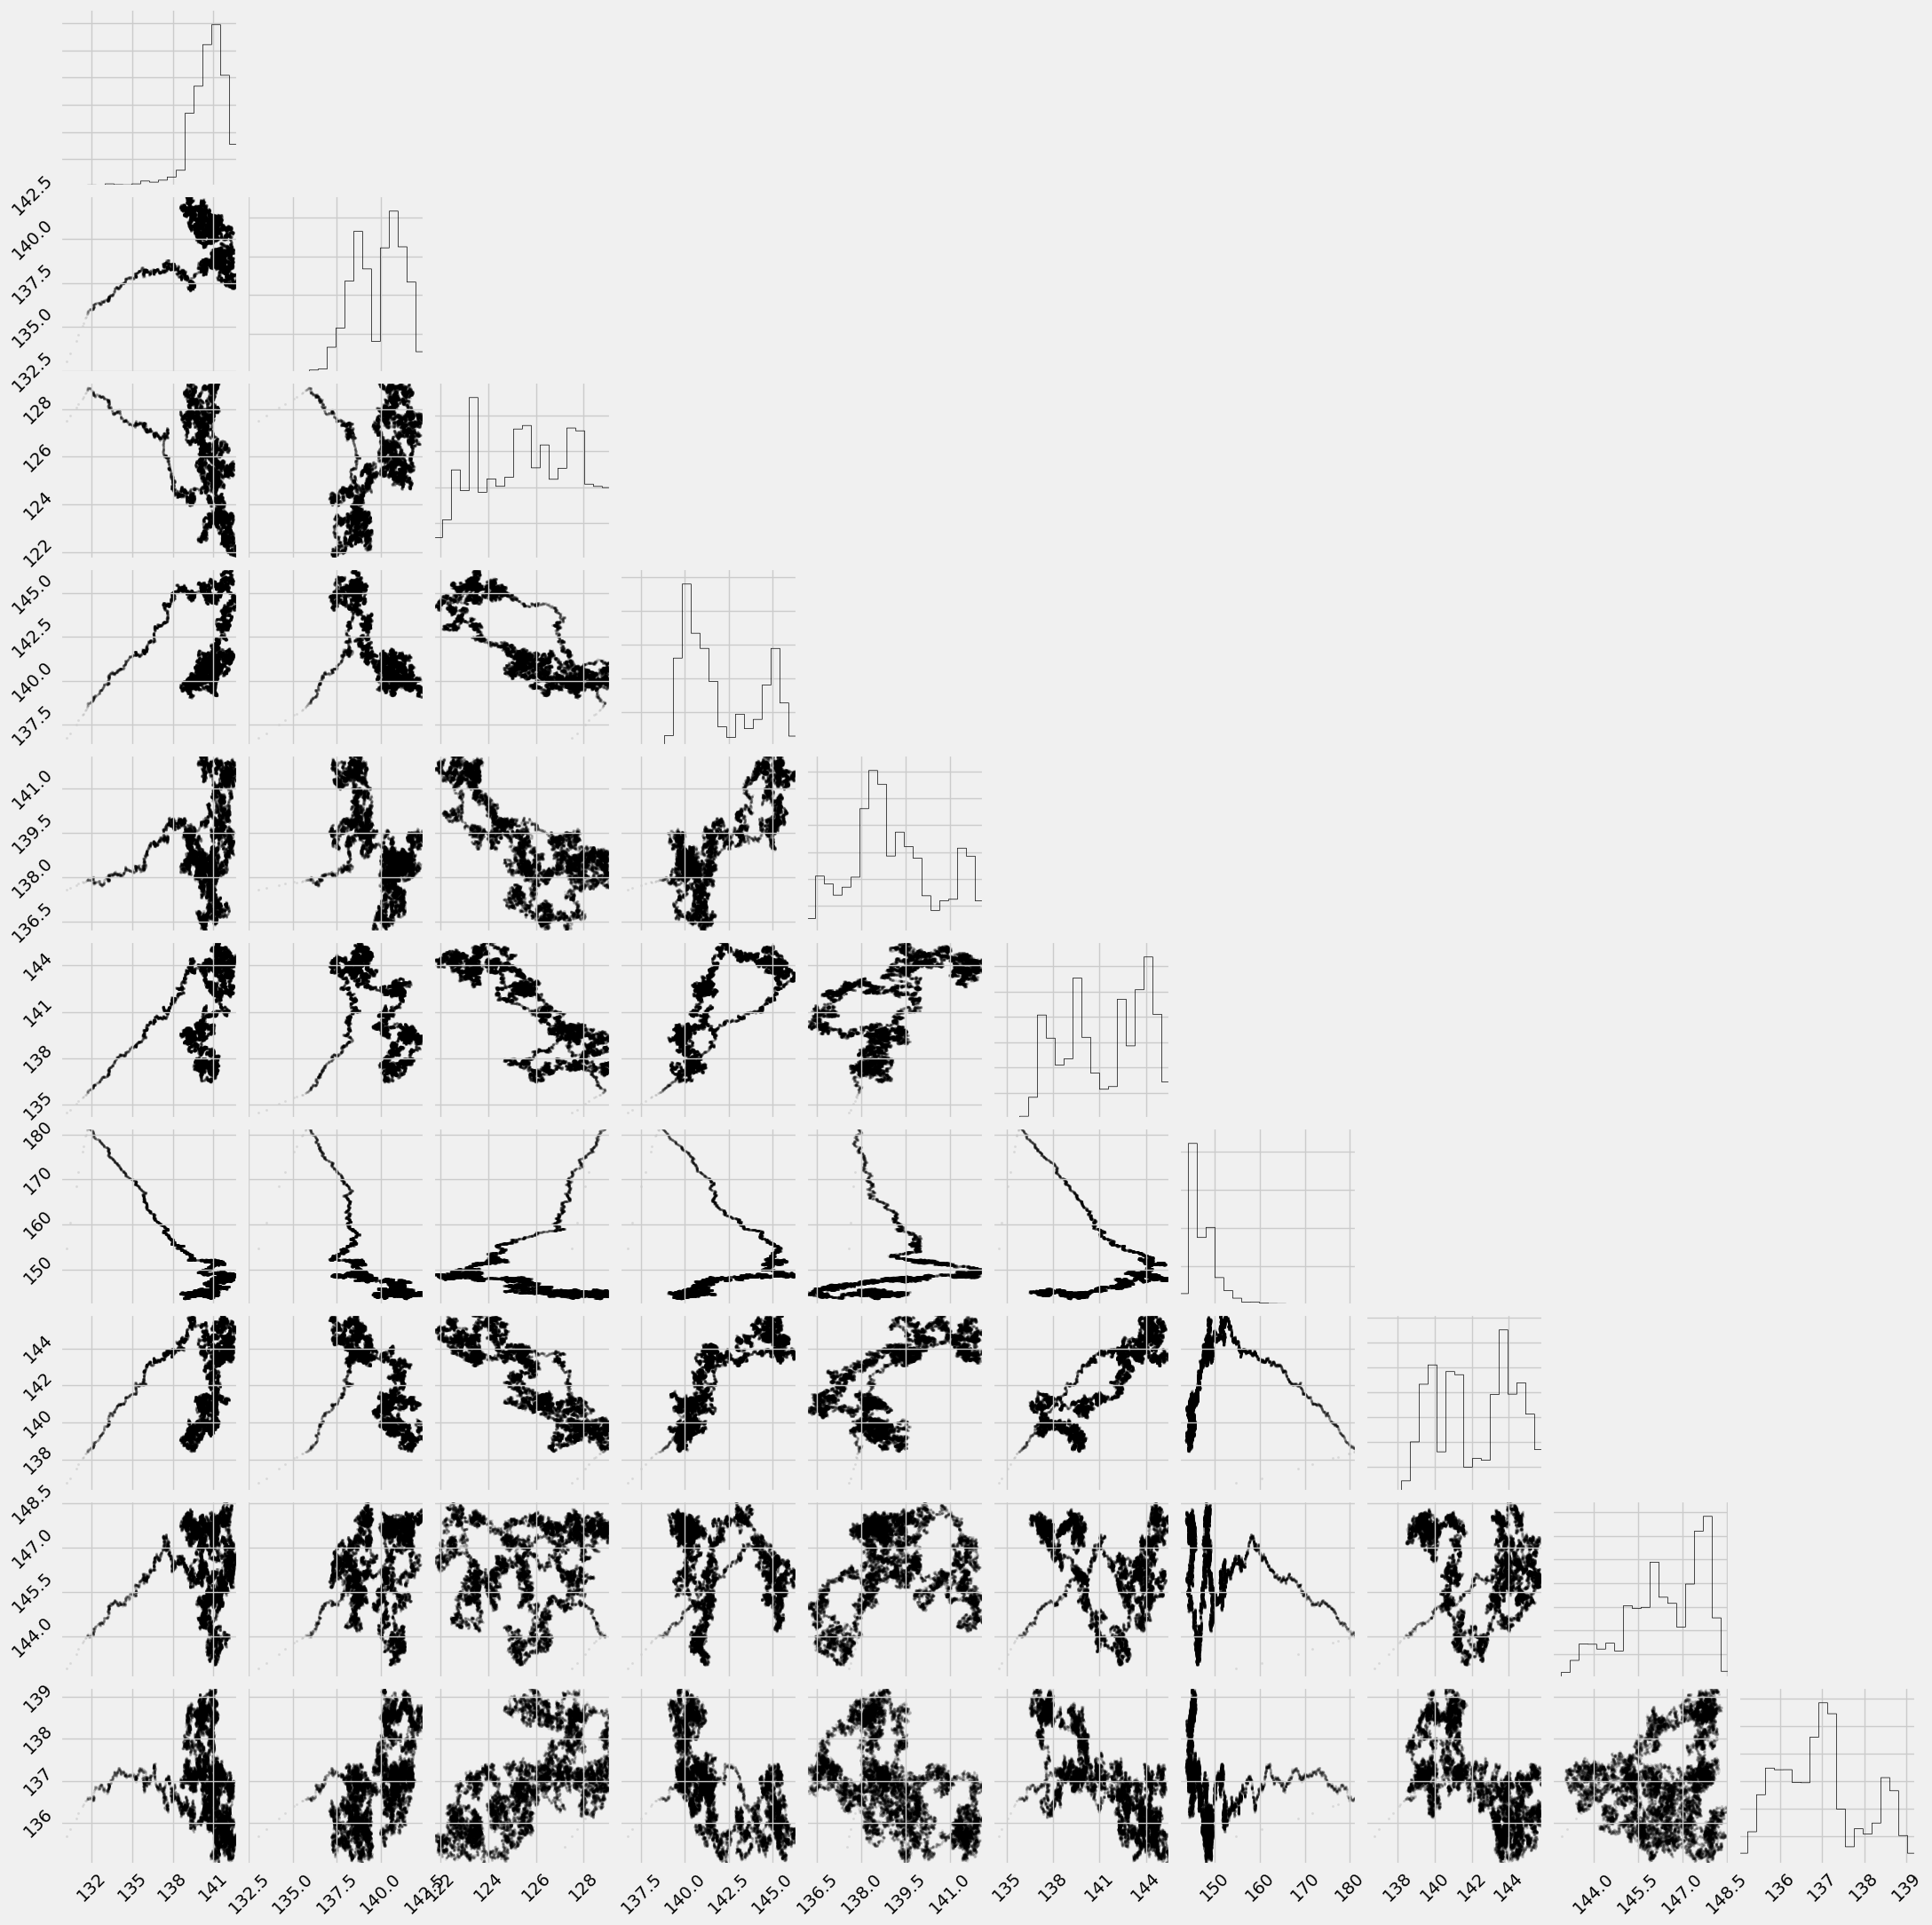

In [58]:
corner.corner(qr.params.eval(), plot_contours=False, plot_density=False,
              truths=1./x_data[ii,0]);

In [70]:
run1 = qv.params.eval()

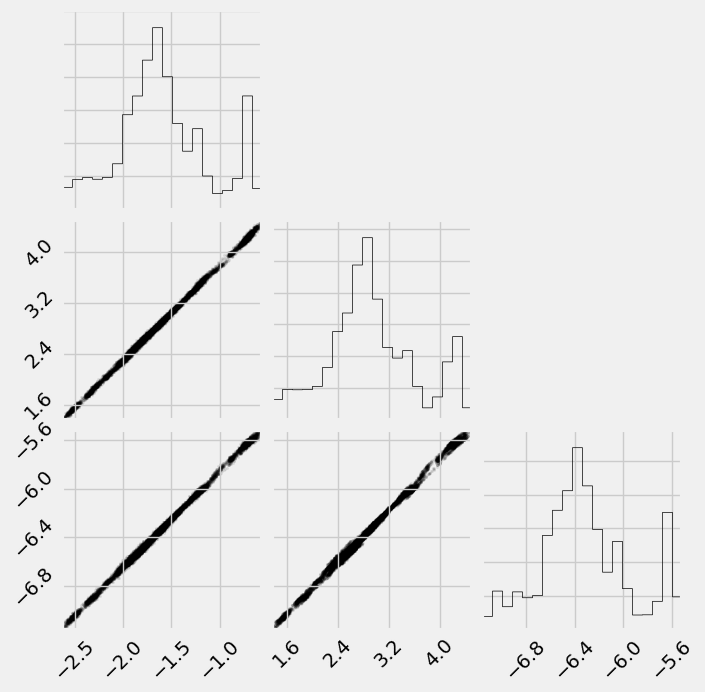

In [65]:
corner.corner(qv.params.eval()[30000:], plot_contours=False, plot_density=False);

(-1, 50000.0)

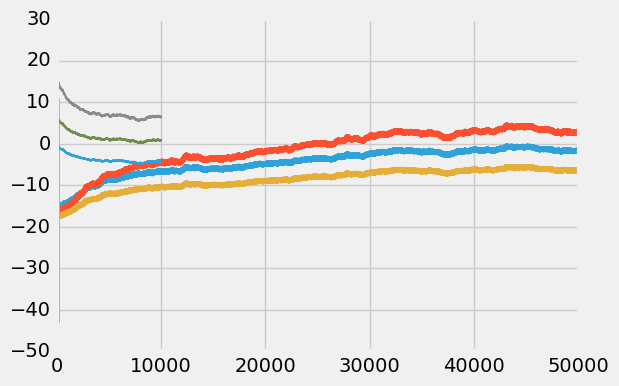

In [87]:
for x in run1.T:
    plt.plot(x)
plt.plot(qv.params.eval()[:,0], lw=1.5);
plt.plot(qv.params.eval()[:,1], lw=1.5);
plt.plot(qv.params.eval()[0:,2], lw=1.5);
plt.xlim(-1)

In [62]:
qv.params.eval()[-1]

array([-1.57673907,  2.91962504, -6.30801916], dtype=float32)

In [78]:
qv.params.eval()[-1]

array([-1.5412513 ,  3.00985169, -6.26076174], dtype=float32)

In [98]:
M_data.shape

(151, 3, 3)

In [104]:
np.einsum('ijk,k->ij',M_data, qv.mean().eval())[:,0]/g.tgas_distance/4.74

391      0.104551
442      0.102838
501      0.099365
715      0.098577
794      0.104669
804      0.095451
1322     0.104130
3079     0.101637
3206     0.109506
3493     0.097771
3795     0.090745
3854     0.102644
3864     0.104645
3875     0.101449
3883     0.100657
3893     0.109982
3905     0.100060
3912     0.107365
4121     0.097177
4855     0.110143
4971     0.103514
5054     0.100776
5117     0.098220
5124     0.102459
5219     0.099792
5231     0.113953
5249     0.099390
5256     0.102079
5257     0.102637
5264     0.094282
           ...   
6167     0.099650
6170     0.101376
6171     0.094641
6182     0.101004
6183     0.098685
6185     0.103208
6187     0.098877
6190     0.099285
6191     0.091895
6193     0.089406
6200     0.095662
6201     0.098650
6203     0.102073
6222     0.100497
6232     0.102220
6247     0.088569
6252     0.103650
6253     0.100299
6256     0.099227
6272     0.092298
6388     0.105152
6455     0.107460
6473     0.095038
6535     0.111910
8389     0

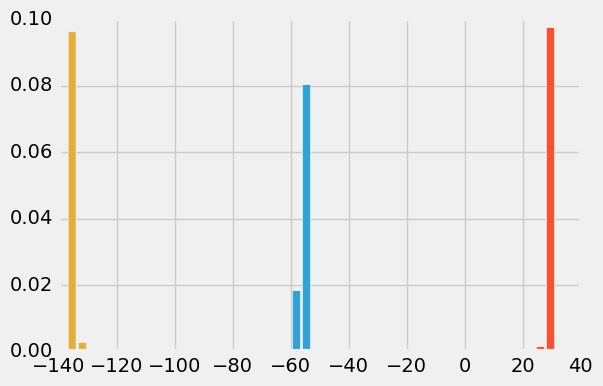

In [83]:
plt.hist(qv.params.eval()[:,:], stacked=True, bins=50, normed=True);
# plt.hist(v.sample(3000).eval()[:,0], bins=50, histtype='step', normed=True);

In [21]:
# x_post = ed.copy(x, {r:qr, v:qv, cov:tf.constant(fakecov**2, tf.float32), M:tf.constant(M_data, tf.float32)})